In [1]:
# import necessary libraries
from googleapiclient.discovery import build
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MultipleLocator

# Data Cleaning & Formatting

In [2]:
# read in csv files to DataFrames
df1 = pd.read_csv('AmazingTalker.csv')
df2 = pd.read_csv('AmazingTalkerShow.csv')

In [3]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1357 entries, 0 to 1356
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   ID                      1357 non-null   object
 1   Title                   1357 non-null   object
 2   Published At            1357 non-null   object
 3   Category                1357 non-null   int64 
 4   Default Audio Language  1203 non-null   object
 5   Duration                1357 non-null   object
 6   Definition              1357 non-null   object
 7   Caption                 1357 non-null   bool  
 8   Licensed                1357 non-null   bool  
 9   Views                   1357 non-null   int64 
 10  Likes                   1357 non-null   int64 
 11  Dislikes                1357 non-null   int64 
 12  Favorites               1357 non-null   int64 
 13  Comments                1357 non-null   int64 
 14  Description             1057 non-null   object
dtypes: b

In [4]:
df1.head(2)

,ID,Title,Published At,Category,Default Audio Language,Duration,Definition,Caption,Licensed,Views,Likes,Dislikes,Favorites,Comments,Description
0,znLBKPOPYWU,你不知道的奧運真相：辦奧運辦到破產！禁藥、賄賂樣樣來⋯⋯我們曾以「台灣」名義出賽奧運？｜驚奇...,2024-07-26T12:01:09Z,27,zh-TW,PT16M53S,hd,False,True,303,23,0,0,0,2024巴黎奧運再幾個小時就要開幕！每四年舉辦一次的奧林匹克運動會，是全球體育的巔峰盛事，大...
1,vPxH9PoegPc,🔍 YouTube搜尋 #驚奇說 ！正片馬上看！#奧運 #歷史 #台灣#AmazingTal...,2024-07-26T12:01:04Z,27,zh-TW,PT30S,hd,False,True,20,2,0,0,1,NaN


_Columns to be modified : 'Published At' (convert to Taipei time), 'Category' (object), 'Duration' (int)_

## 1. Format 'Published At' to Taipei datetime

In [5]:
# create a function to convert Published At to Taipei datetime and store dates and times separately in new columns
def convert_datetime(df):
    
    # convert to datetime object
    df['Published At'] = pd.to_datetime(df['Published At'], format='%Y-%m-%dT%H:%M:%SZ', errors='coerce')

    # convert UTC to Taipei time
    df['Published At'] = df['Published At'].dt.tz_localize('UTC').dt.tz_convert('Asia/Taipei')

convert_datetime(df1)
convert_datetime(df2)

In [6]:
df1[['Published At']].head(2)

,Published At
0,2024-07-26 20:01:09+08:00
1,2024-07-26 20:01:04+08:00


## 2. Replace 'Category' code with category name

In [7]:
# define API key and parameters for YouTube Data API
api_key = 'API_KEY'
youtube = build('youtube', 'v3', developerKey=api_key)  

# define a function to replace Category numbers with corresponding category names
def category_number_to_name(df):
    
    # define a dictionary category_list to store category ID and name pairs
    category_dict = dict()
    
    # loop through unique category IDs in the DataFrame, retrieve category names through YouTube Data API, and add category ID and name pairs to the dictionary
    for category_id in df['Category'].unique():
        request = youtube.videoCategories().list(
            part='snippet',
            id=category_id
        )
        response_category = request.execute()
    
        category_dict[category_id] = response_category['items'][0]['snippet']['title']

    # update Category values
    df['Category'] = df['Category'].map(category_dict)

category_number_to_name(df1)
category_number_to_name(df2)

In [8]:
df1['Category'].value_counts()

Category
Education         1234
People & Blogs     123
Name: count, dtype: int64

## 3. Convert 'Duration' to seconds

In [9]:
# define a function to convert hours in a duration string to seconds 
def durationHours_to_seconds(n):
    try:
        return int(re.search(r'([0-9]+)H', n).group(1)) * 3600
    except AttributeError:
        return 0

# define a function to convert minutes in a duration string to seconds
def durationMinutes_to_seconds(n):
    try:
        return int(re.search(r'([0-9]+)M', n).group(1)) * 60
    except AttributeError:
        return 0

# define a function the extract the seconds from a duration string
def durationSeconds(n):
    try:
        return int(re.search(r'([0-9]+)S', n).group(1))
    except AttributeError:
        return 0

# define a function to convert a duration string to seconds
def convert_duration_string_to_seconds(df):
    df['Duration'] = df['Duration'].apply(lambda x: durationHours_to_seconds(x) + durationMinutes_to_seconds(x) + durationSeconds(x))

convert_duration_string_to_seconds(df1)
convert_duration_string_to_seconds(df2)

In [10]:
df1['Duration'].head(2)

0    1013
1      30
Name: Duration, dtype: int64

## 4. Create video 'URL' column

In [11]:
# define a function to create URL from the ID column
def create_url(df):
    df['URL'] = 'https://www.youtube.com/watch?v=' + df['ID']

create_url(df1)
create_url(df2)

In [12]:
df1[['ID', 'URL']].head(2)

,ID,URL
0,znLBKPOPYWU,https://www.youtube.com/watch?v=znLBKPOPYWU
1,vPxH9PoegPc,https://www.youtube.com/watch?v=vPxH9PoegPc


In [13]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1357 entries, 0 to 1356
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype                      
---  ------                  --------------  -----                      
 0   ID                      1357 non-null   object                     
 1   Title                   1357 non-null   object                     
 2   Published At            1357 non-null   datetime64[ns, Asia/Taipei]
 3   Category                1357 non-null   object                     
 4   Default Audio Language  1203 non-null   object                     
 5   Duration                1357 non-null   int64                      
 6   Definition              1357 non-null   object                     
 7   Caption                 1357 non-null   bool                       
 8   Licensed                1357 non-null   bool                       
 9   Views                   1357 non-null   int64                      
 10  Likes       

In [14]:
df1.head(2)

,ID,Title,Published At,Category,Default Audio Language,Duration,Definition,Caption,Licensed,Views,Likes,Dislikes,Favorites,Comments,Description,URL
0,znLBKPOPYWU,你不知道的奧運真相：辦奧運辦到破產！禁藥、賄賂樣樣來⋯⋯我們曾以「台灣」名義出賽奧運？｜驚奇...,2024-07-26 20:01:09+08:00,Education,zh-TW,1013,hd,False,True,303,23,0,0,0,2024巴黎奧運再幾個小時就要開幕！每四年舉辦一次的奧林匹克運動會，是全球體育的巔峰盛事，大...,https://www.youtube.com/watch?v=znLBKPOPYWU
1,vPxH9PoegPc,🔍 YouTube搜尋 #驚奇說 ！正片馬上看！#奧運 #歷史 #台灣#AmazingTal...,2024-07-26 20:01:04+08:00,Education,zh-TW,30,hd,False,True,20,2,0,0,1,NaN,https://www.youtube.com/watch?v=vPxH9PoegPc


***

# Data Analysis & Visualisation

In [15]:
# change display option to show maximum 100 characters
pd.options.display.max_colwidth = 100

# suppress scientific notation by setting float_format
pd.options.display.float_format = '{:.0f}'.format

## 1. General Statistics

### 1.1. Video counts

In [16]:
df1.shape[0]

1357

In [17]:
df2.shape[0]

240

_1357 videos on the AmazingTalker channel vs 240 videos on the AmazingTalker Show channel (till 2024/07/27)_

### 1.2. Published dates of the first videos

In [18]:
df1['Published At'].min()

Timestamp('2016-11-21 18:02:33+0800', tz='Asia/Taipei')

In [19]:
df2['Published At'].min()

Timestamp('2021-01-15 21:01:28+0800', tz='Asia/Taipei')

_First video published in 2016 on the AmazingTalker channel vs 2021 on the AmazingTalker Show channel_

### 1.3. Comparison of numerical values (duration, views, likes, dislikes, favorites, comments)

In [20]:
pd.concat([df1.describe(), df2.describe()], keys=['AmazingTalker', 'AmazingTalker Show'], axis=1)

AmazingTalker                                             \
           Duration   Views  Likes Dislikes Favorites Comments   
count          1357    1357   1357     1357      1357     1357   
mean             91  122812   2765        0         0       30   
std             182  354222   9166        0         0       80   
min               7      20      0        0         0        0   
25%              25    2104     18        0         0        0   
50%              39   19420    318        0         0        5   
75%              82   71327   1411        0         0       22   
max            1389 4549754 128196        0         0      897   

      AmazingTalker Show                                             
                Duration   Views  Likes Dislikes Favorites Comments  
count                240     240    240      240       240      240  
mean                 861  519747   9363        0         0      262  
std                  344  530015  11890        0         0      305  
min                   29   34932    655        0         0        3  
25%                  763  172136   2953        0         0      104  
50%                  924  308272   4800        0         0      173  
75%                 1013  696348  11535        0         0      316  
max                 2648 3488330 108844        0         0     3068

* _**Duration:** Overall, videos on the AmazingTalker channel are significantly shorter than those on the AmazingTalker Show channel, having lower mean, minimum, and maximum durations. .75% of the videos on the AmazingTalker channel are under 1.5 minutes._
* _**Views:** View counts on the AmazingTalker Show channel are more evenly distributed, as indicated by a smaller standard deviation and a narrower range between minimum and maximum views. While the AmazingTalker channel has a higher maximum view count, 75% of its videos have fewer than 72k views. The AmazingTalker Show channel also boasts a higher average view count than the AmazingTalker channel._
* _**Dislikes & Favorites:** Neither channel has any dislikes or favorites._
* _**Comments:** The AmazingTalker Show channel has an average comment count more than eight times higher than that of the AmazingTalker channel. Furthermore, over 75% of the videos on the AmazingTalker Show channel receive more than 100 comments._

In [21]:
df1[['Views', 'Likes', 'Comments']].sum()

Views       166656528
Likes         3752560
Comments        40518
dtype: int64

In [22]:
df2[['Views', 'Likes', 'Comments']].sum()

Views       124739277
Likes         2247013
Comments        62975
dtype: int64

* _**Total views, likes, and comments:** With a longer history and more than five times the number of videos uploaded, the AmazingTalker channel surpasses the AmazingTalker Show channel in cumulative view and like counts. However, the AmazingTalker Show channel has a higher cumulative comment count, indicating greater viewer engagement and interactivity._

_The two channels appear to adopt different strategies regarding video length. The AmazingTalker channel focuses on short-form content, aligning with the recent trend of short videos, while the AmazingTalker Show channel predominantly uploads videos longer than 10 minutes. In terms of overall channel success, the AmazingTalker Show channel outperforms in view, like, and comment counts._

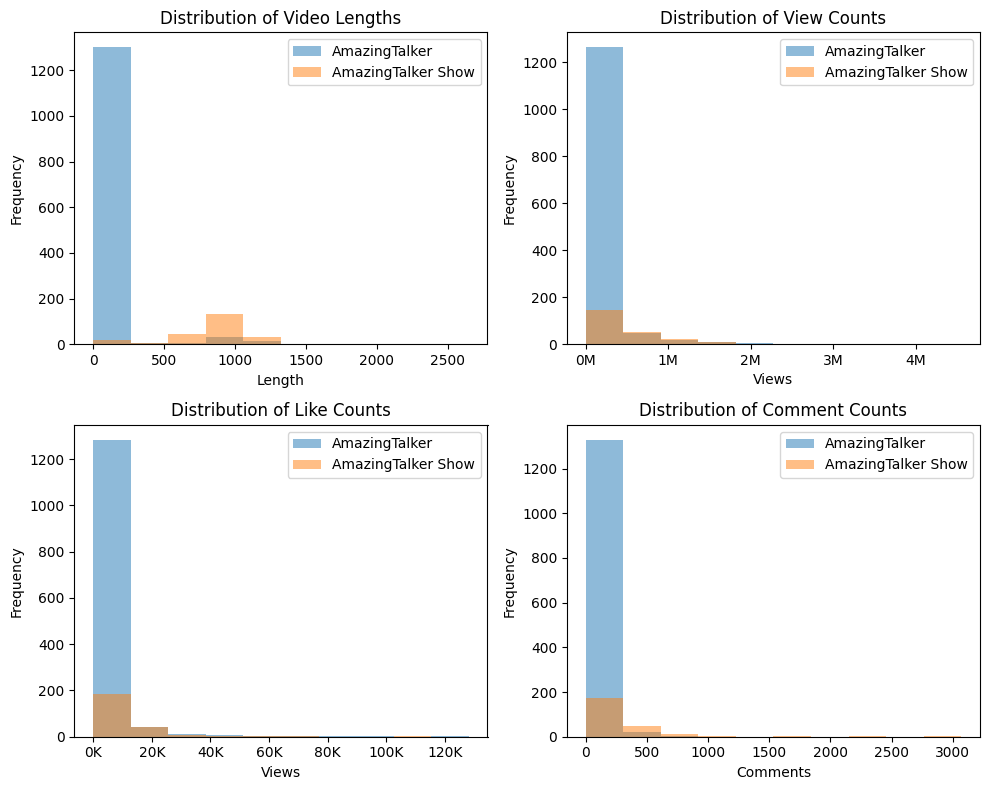

In [23]:
fig, ax = plt.subplots(2, 2, figsize=(10, 8))

ax1 = ax[0, 0]
ax2 = ax[0, 1]
ax3 = ax[1, 0]
ax4 = ax[1, 1]

# visualise the distribution of video duration
df1['Duration'].plot(kind='hist', alpha=0.5, bins=10, range=(0, 2648), label='AmazingTalker', ax=ax1)
df2['Duration'].plot(kind='hist', alpha=0.5, bins=10, range=(0, 2648), label='AmazingTalker Show', ax=ax1)

ax1.set_title('Distribution of Video Lengths')
ax1.set_xlabel('Length')
ax1.set_ylabel('Frequency')
ax1.legend()

# visualise the distribution of view counts
df1['Views'].plot(kind='hist', alpha=0.5, bins=10, range=(0, 4549754), label='AmazingTalker', ax=ax2)
df2['Views'].plot(kind='hist', alpha=0.5, bins=10, range=(0, 4549754), label='AmazingTalker Show', ax=ax2)

ax2.set_title('Distribution of View Counts')
ax2.set_xlabel('Views')
ax2.set_ylabel('Frequency')
ax2.set_xticks(ax2.get_xticks()[1:-1])
ax2.set_xticklabels(['{:.0f}'.format(x) + 'M' for x in ax2.get_xticks() / 1000000])
ax2.legend()

# visualise the distribution of like counts
df1['Likes'].plot(kind='hist', alpha=0.5, bins=10, range=(0, 128196), label='AmazingTalker', ax=ax3)
df2['Likes'].plot(kind='hist', alpha=0.5, bins=10, range=(0, 128196), label='AmazingTalker Show', ax=ax3)

ax3.set_title('Distribution of Like Counts')
ax3.set_xlabel('Views')
ax3.set_ylabel('Frequency')
ax3.set_xticks(ax3.get_xticks()[1:-1])
ax3.set_xticklabels(['{:.0f}'.format(x) + 'K' for x in ax3.get_xticks() / 1000])
ax3.legend()

# visualise the distribution of comment counts
df1['Comments'].plot(kind='hist', alpha=0.5, bins=10, range=(0, 3068), label='AmazingTalker', ax=ax4)
df2['Comments'].plot(kind='hist', alpha=0.5, bins=10, range=(0, 3068), label='AmazingTalker Show', ax=ax4)

ax4.set_title('Distribution of Comment Counts')
ax4.set_xlabel('Comments')
ax4.set_ylabel('Frequency')
ax4.legend()

plt.tight_layout()

### 1.4. Top 10 videos by view, like, and comment counts

In [24]:
# AmazingTalker channel
pd.concat(
    [
        df1.sort_values(by='Views', ascending=False)[['Title', 'Views', 'Duration', 'Published At']].head(10).reset_index(drop=True),
        df1.sort_values(by='Likes', ascending=False)[['Title', 'Likes', 'Duration', 'Published At']].head(10).reset_index(drop=True),
        df1.sort_values(by='Comments', ascending=False)[['Title', 'Comments', 'Duration', 'Published At']].head(10).reset_index(drop=True)
    ],
    keys=['AmazingTalker Top 10 Views', 'Top 10 Lkes', 'Top 10 Comments'],
    axis=1
)

AmazingTalker Top 10 Views  \
                                                                       Title   
0            陳柏霖教你 原來如此 英文怎麼說？ #陳柏霖 #驚奇玩起來 #reels #AmazingTalker #線上英文家教 #英語   
1  伍佰爆怒美腔「偽」英文？來學「Often」的正確發音！ #伍佰 #驚奇玩起來 #shorts #AmazingTalker #線上英文家教 #英語   
2                                                         陳芳語美式口音讓Eko老師快抓狂！？   
3                                          Kimberley澳洲口音嚇壞Eko！“Emo”竟然是澳式英文？！   
4                                              蔡恩雨示範「馬來西亞」英文！原來塞車他們都說ＸＸ.....   
5                                                   百靈果 podcast 之王 嗆爆驚奇脫口秀！！   
6                               吳卓源 Julia 爆笑「澳洲口音」氣死 Eko？Sandra 超愛澳洲人生氣都這樣說！   
7                            【AmazingTalker】 線上語言家教媒合平台，超過 30 個國家的教師朋友等你來探索！   
8                                                鳳小岳崇尚英腔？從”漢堡”與”薯條“聊到英美口音之爭！   
9                                                             法國路易嗆爆Eko英式口音？   

                                               \
     Views Duration              Published At   
0  4549754       35 2023-11-11 21:53:31+08:00   
1  3929205       37 2023-08-12 20:36:57+08:00   
2  3710518       16 2022-07-07 18:46:17+08:00   
3  3083154       19 2022-08-14 19:00:24+08:00   
4  3044874       20 2022-09-18 19:00:31+08:00   
5  2602363       38 2023-07-08 19:56:40+08:00   
6  2581667       37 2022-12-18 20:02:20+08:00   
7  2343730       15 2017-07-06 10:45:04+08:00   
8  2260064       42 2023-08-26 19:48:12+08:00   
9  2216822       26 2022-10-21 19:00:02+08:00   

                                                                 Top 10 Lkes  \
                                                                       Title   
0            陳柏霖教你 原來如此 英文怎麼說？ #陳柏霖 #驚奇玩起來 #reels #AmazingTalker #線上英文家教 #英語   
1                                                             法國路易嗆爆Eko英式口音？   
2                                                         陳芳語美式口音讓Eko老師快抓狂！？   
3                                              蔡恩雨示範「馬來西亞」英文！原來塞車他們都說ＸＸ.....   
4  伍佰爆怒美腔「偽」英文？來學「Often」的正確發音！ #伍佰 #驚奇玩起來 #shorts #AmazingTalker #線上英文家教 #英語   
5                                                   百靈果 podcast 之王 嗆爆驚奇脫口秀！！   
6                                          Kimberley澳洲口音嚇壞Eko！“Emo”竟然是澳式英文？！   
7                                                鳳小岳崇尚英腔？從”漢堡”與”薯條“聊到英美口音之爭！   
8    盧貝松教你法文的唯一秘訣！這個字的發音亞洲人都不會？#盧貝松 #驚奇玩起來 #reels #AmazingTalker #線上英文家教 #英語   
9                               吳卓源 Julia 爆笑「澳洲口音」氣死 Eko？Sandra 超愛澳洲人生氣都這樣說！   

                                              \
    Likes Duration              Published At   
0  128196       35 2023-11-11 21:53:31+08:00   
1   94675       26 2022-10-21 19:00:02+08:00   
2   94341       16 2022-07-07 18:46:17+08:00   
3   90665       20 2022-09-18 19:00:31+08:00   
4   86433       37 2023-08-12 20:36:57+08:00   
5   85798       38 2023-07-08 19:56:40+08:00   
6   85690       19 2022-08-14 19:00:24+08:00   
7   65022       42 2023-08-26 19:48:12+08:00   
8   58391       34 2024-01-29 20:22:20+08:00   
9   53478       37 2022-12-18 20:02:20+08:00   

                                Top 10 Comments                    \
                                          Title Comments Duration   
0           「我想要」才不是「I want」？Eko驚曝：跟老外講英文不會進步！？      897       29   
1                 蔡恩雨示範「馬來西亞」英文！原來塞車他們都說ＸＸ.....      834       20   
2                          最常用的文法！Eko教你「子句」這樣說！      751       24   
3                           男性自古有特權？！性別平等英文你會嗎？      717       39   
4             「幫我一下！」英文你也會跟他們一樣講錯嗎？Eko教你這樣說更勁爆！      695       22   
5             Kimberley澳洲口音嚇壞Eko！“Emo”竟然是澳式英文？！      554       19   
6  「越來越」你也只會說「more and more」？Eko 教一個你一定聽過的高級用法！      527       24   
7                           👉 留言告訴小編 F for ...？      517       19   
8                            陳芳語美式口音讓Eko老師快抓狂！？      500       16   
9                   鳳小岳崇尚英腔？從”漢堡”與”薯條“聊到英美口音之爭！      487       42   

                             
               Published At  
0 2022-12-22 19:53:01+08:00  
1 2022-09-18 19:00:31+08:00  
2 2023-03-29 

In [25]:
# AmazingTalker Show channel
pd.concat(
    [
        df2.sort_values(by='Views', ascending=False)[['Title', 'Views', 'Duration', 'Published At']].head(10).reset_index(drop=True),
        df2.sort_values(by='Likes', ascending=False)[['Title', 'Likes', 'Duration', 'Published At']].head(10).reset_index(drop=True),
        df2.sort_values(by='Comments', ascending=False)[['Title', 'Comments', 'Duration', 'Published At']].head(10).reset_index(drop=True)
    ],
    keys=['AmazingTalker Show Top 10 vVews', 'Top 10 Likes', 'Top 10 Comments'],
    axis=1
)

AmazingTalker Show Top 10 vVews  \
                                                                                  Title   
0                          ☝🏼沒認真唸英文 卻英文超好？Eko親弟爆料他英國口音都是裝的！ #驚奇脫口秀 #amazingtalker #時不我予   
1       柯文哲寫英文論文超簡單?! 最正經的市長大開幹話模式？Sandra竟然比學姐年輕? 阿北愛恨不需要理由？| ( ft. @Team__KP ）驚奇脫口秀#82   
2             陳芳語首次公開出櫃！Eko被讚英文最有質感?? 七分編湊合兩人竟是失散知音???| ( ft.@itsKimberleyChen）驚奇脫口秀#45   
3                  ☝🏼教法國人正統法文？潘若迪精通英法文超強的？ feat. @FunkyDance #驚奇脫口秀 #amazingtalker #潘若迪   
4                 胡宇威竟是美國人英文超完美!? Eko與宇威甜蜜接觸直擊?? 不老基因秘密大公開!! | (ft. 胡宇威/親愛的亞當 ）驚奇脫口秀#58   
5               ☝🏼床事法文是「XX爆炸」？潘若迪60歲沒體力做了？  Feat.@FunkyDance #驚奇脫口秀 #amazingtalker #潘若迪   
6    薔薔辦告別單身趴幫Eko轉大人？Eko對情趣用品的英文瞭若指掌？Sandra控制不住薔薔乾脆一起調戲Eko？ | ( ft.@maze0517  ）驚奇脫口秀#40   
7    百靈果Podcast之王登場，凱莉口譯電爆Sandra!? Ken竟會這樣裸奔!? Eko拋棄夥伴看戲！| ( ft.@bailingguo  ）驚奇脫口秀#127   
8  伍佰搖滾傳奇降臨!! Eko跟傳奇竟然一拍即合!? 伍佰喜歡英腔還是美腔!? Sandra記錯歌詞被臭罵!?| ( ft. @clubwubai  ）驚奇脫口秀#133   
9    泰國娘娘 花式開嗆Eko不簡單?! 罵人英文竟也有好的意涵? 勁辣內容讓Eko＋Sandra招架不住? | ( ft.@alizabethlin ）驚奇脫口秀#53   

                                               \
     Views Duration              Published At   
0  3488330       31 2024-05-08 18:00:19+08:00   
1  3203096     1075 2022-10-16 19:30:09+08:00   
2  2664711     1202 2022-03-27 20:11:44+08:00   
3  2497542       47 2024-05-30 18:09:26+08:00   
4  2098464      851 2022-06-05 19:00:42+08:00   
5  1998998       42 2024-05-27 18:40:00+08:00   
6  1824259      927 2022-02-18 19:30:19+08:00   
7  1772195     1133 2023-06-11 19:30:03+08:00   
8  1680331      963 2023-07-16 19:30:26+08:00   
9  1630199     1089 2022-05-08 21:37:47+08:00   

                                                                           Top 10 Likes  \
                                                                                  Title   
0                          ☝🏼沒認真唸英文 卻英文超好？Eko親弟爆料他英國口音都是裝的！ #驚奇脫口秀 #amazingtalker #時不我予   
1                  ☝🏼教法國人正統法文？潘若迪精通英法文超強的？ feat. @FunkyDance #驚奇脫口秀 #amazingtalker #潘若迪   
2               ☝🏼床事法文是「XX爆炸」？潘若迪60歲沒體力做了？  Feat.@FunkyDance #驚奇脫口秀 #amazingtalker #潘若迪   
3       柯文哲寫英文論文超簡單?! 最正經的市長大開幹話模式？Sandra竟然比學姐年輕? 阿北愛恨不需要理由？| ( ft. @Team__KP ）驚奇脫口秀#82   
4   ☝🏼江老師被Sandra惹怒！古典義大利文反嗆主持人？ Feat.@iamteacherchiang  #驚奇脫口秀 #amazingtalker #江老師 #古典樂   
5             陳芳語首次公開出櫃！Eko被讚英文最有質感?? 七分編湊合兩人竟是失散知音???| ( ft.@itsKimberleyChen）驚奇脫口秀#45   
6                      ☝🏼美國台灣媳婦莎白！Eko抱怨台灣路口很差沒法律  #驚奇脫口秀 #amazingtalker #莎白  #Eko #台灣媳婦   
7                               ☝🏼鄭中基教你廣東話髒話！開黃色笑話讓Sandra羞紅臉！#驚奇脫口秀 #amazingtalker #鄭中基   
8  ☝🏼Dodomen在美國被霸凌?!講What’s up而被黑人欺負？ Feat. @TheDoDoMen  #驚奇脫口秀 #amazingtalker #dodomen   
9                                    ☝🏼劉品言示範法文點餐！用浪漫語言調情服務生？ #驚奇脫口秀 #amazingtalker #劉品言   

                                              \
    Likes Duration              Published At   
0  108844       31 2024-05-08 18:00:19+08:00   
1   64993       47 2024-05-30 18:09:26+08:00   
2   57562       42 2024-05-27 18:40:00+08:00   
3   53797     1075 2022-10-16 19:30:09+08:00   
4   44984       42 2024-05-20 18:34:19+08:00   
5   44123     1202 2022-03-27 20:11:44+08:00   
6   42478       48 2024-07-01 18:40:00+08:00   
7   39746       43 2024-06-14 19:00:24+08:00   
8   34771       39 2024-05-23 18:30:11+08:00   
9   33772       33 2024-05-10 19:00:29+08:00   

                                                                                   Top 10 Comments  \
                                                                                             Title   
0                  柯文哲寫英文論文超簡單?! 最正經的市長大開幹話模式？Sandra竟然比學姐年輕? 阿北愛恨不需要理由？| ( ft. @Team__KP ）驚奇脫口秀#82   
1                      賴清德最愛台灣腔英文?!現場爆氣大罵Sandra Eko?!唸哈佛原來是因為宗教關係!!| ft @Chingte_Taiwan  驚奇脫口秀#160   
2                     宋楚瑜獻唱英文歌!! 跨世代英文口譯對決!? 訓斥Eko Sandra粗俗 聽不懂人話?!  | ( ft. @soong6277 ）驚奇脫口秀#168   
3                             ☝🏼教法國人正統法文？潘若迪精通英法文超強的？ feat. @FunkyDance #驚奇脫口秀 #amazingtalker #潘若迪   
4               百靈果Podcast之王登場，凱莉口譯電爆Sandra!? Ken竟會這樣裸奔!? Eko拋棄夥伴看戲！| ( ft.@bailingguo  ）驚奇脫

## 2. Publishing frequency & consistency

### 2.1. Number of videos published over time (monthly)

C:\Users\maggi\AppData\Local\Temp\ipykernel_11280\2094593489.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  pov1 = df1.groupby(df1['Published At'].dt.to_period('M')).size().reset_index(name='Count')
C:\Users\maggi\AppData\Local\Temp\ipykernel_11280\2094593489.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  pov2 = df2.groupby(df2['Published At'].dt.to_period('M')).size().reset_index(name='Count')


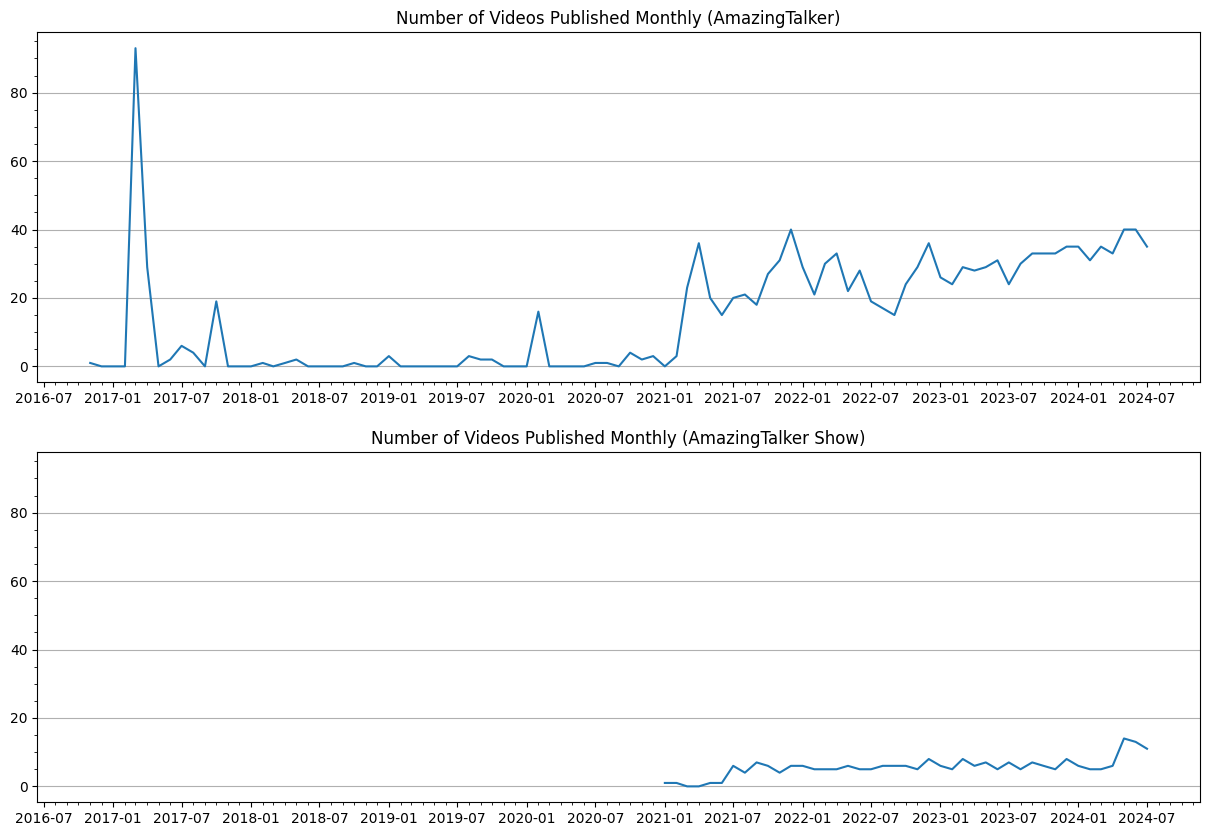

In [26]:
# group by year and month, and count the number of videos uploaded each month
pov1 = df1.groupby(df1['Published At'].dt.to_period('M')).size().reset_index(name='Count')
pov2 = df2.groupby(df2['Published At'].dt.to_period('M')).size().reset_index(name='Count')
pov1['Published At'] = pov1['Published At'].dt.to_timestamp()
pov2['Published At'] = pov2['Published At'].dt.to_timestamp()

# create a complete date range from the start to the end of the data
date_range1 = pd.date_range(start=pov1['Published At'].min(), end=pov1['Published At'].max(), freq='MS')
date_range2 = pd.date_range(start=pov2['Published At'].min(), end=pov2['Published At'].max(), freq='MS')

# reindex the dataframe to include all months, filling missing values with 0
pov1 = pov1.set_index('Published At').reindex(date_range1, fill_value=0).rename_axis('Published At').reset_index()
pov2 = pov2.set_index('Published At').reindex(date_range2, fill_value=0).rename_axis('Published At').reset_index()

# plot line charts
fig, ax = plt.subplots(2, 1, figsize=(15, 10))

ax1 = ax[0]
ax2 = ax[1]

ax1.plot(pov1['Published At'], pov1['Count'])
ax2.plot(pov2['Published At'], pov2['Count'])

# set major ticks format and location for the x-axis
ax1.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax2.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# set minor ticks location for the x-axis
ax1.xaxis.set_minor_locator(mdates.MonthLocator())
ax2.xaxis.set_minor_locator(mdates.MonthLocator())

# set minor ticks location for the y-axis
ax1.yaxis.set_minor_locator(MultipleLocator(5))
ax2.yaxis.set_minor_locator(MultipleLocator(5))

# add grid lines
ax1.grid(axis='y')
ax2.grid(axis='y')

# add titles
ax1.set_title('Number of Videos Published Monthly (AmazingTalker)')
ax2.set_title('Number of Videos Published Monthly (AmazingTalker Show)')

# standardise xlim and ylim
ax2.set_xlim(ax1.get_xlim())
ax2.set_ylim(ax1.get_ylim())

plt.show()

_As can be seen from the line charts above, videos on the AmazingTalker channel had not not published regularly, having some months with a great amount of videos published and some other with no video uploaded at all, until 2021, about the same time when the AmazingTalker Show channel was activated._

### 2.2. Calculating days between every two consecutive publishing dates

In [27]:
# caluclate days between every two consicutive uploads
pf1 = df1['Published At'].sort_values().diff().dt.days.reset_index(drop=True, name='Diff')
pf2 = df2['Published At'].sort_values().diff().dt.days.reset_index(drop=True, name='Diff')

In [28]:
# show statistics for video publishing frequency
pd.concat(
    [pf1.describe(), pf2.describe()],
    keys=['AmazingTalker', 'AmazingTalker Show'],
    axis=1
)

,AmazingTalker,AmazingTalker Show
count,1356,239
mean,2,5
std,11,7
min,0,0
25%,0,3
50%,0,4
75%,1,6
max,226,98


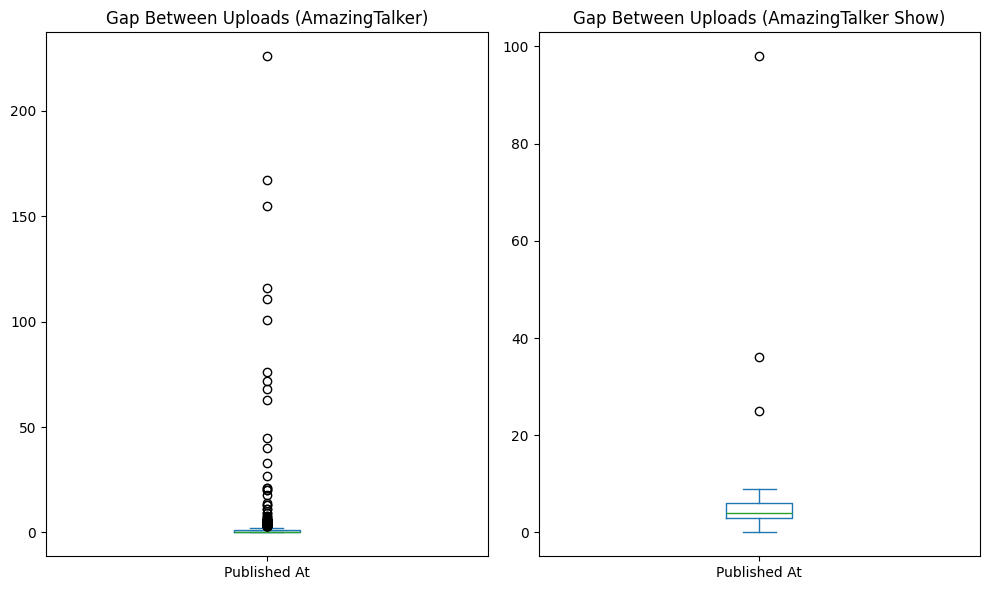

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6))

ax1 = ax[0]
ax2 = ax[1]

pf1.plot(kind='box', ax=ax1)
pf2.plot(kind='box', ax=ax2)

ax1.set_title('Gap Between Uploads (AmazingTalker)')
ax2.set_title('Gap Between Uploads (AmazingTalker Show)')

plt.tight_layout()

_The AmazingTalker Show channel exhibits a more regular video publishing pattern, with an average of 5 days between uploads and only 3 outliers in the box plot. In contrast, the AmazingTalker channel has a shorter average of 1 day between uploads but features numerous outliers, with a maximum gap of 226 days between uploads._

### 2.3. Most common publishing days of week

In [30]:
df1.groupby([df1['Published At'].dt.dayofweek + 1, df1['Published At'].dt.day_name()]).size()

Published At  Published At
1             Monday          141
2             Tuesday         165
3             Wednesday       165
4             Thursday        233
5             Friday          402
6             Saturday        146
7             Sunday          105
dtype: int64

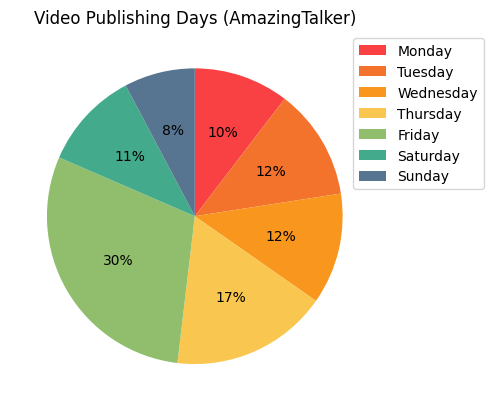

In [31]:
colors = ['#f94144', '#f3722c', '#f8961e', '#f9c74f', '#90be6d', '#43aa8b', '#577590']

fig, ax = plt.subplots()

df1.groupby([df1['Published At'].dt.dayofweek + 1, df1['Published At'].dt.day_name()]).size().plot(
    kind='pie', colors=colors, labels=None, startangle=90, counterclock=False, autopct='%1.0f%%')

ax.set_title('Video Publishing Days (AmazingTalker)')
plt.legend(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], bbox_to_anchor=(1.3, 1.0))

_Friday is the most common publishing day for the AmazingTalker channel, with approximately 30 percent of all videos uploaded on this day, followed by Thursday, which accounts for around 17 percent._

In [32]:
df2.groupby([df2['Published At'].dt.dayofweek + 1, df2['Published At'].dt.day_name()]).size()

Published At  Published At
1             Monday           14
2             Tuesday           6
3             Wednesday        47
4             Thursday         24
5             Friday           28
6             Saturday          8
7             Sunday          113
dtype: int64

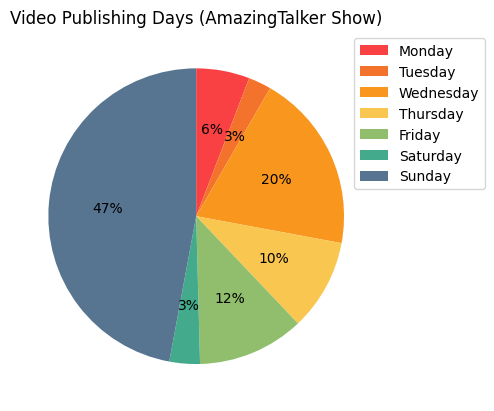

In [33]:
fig, ax = plt.subplots()

df2.groupby([df2['Published At'].dt.dayofweek + 1, df2['Published At'].dt.day_name()]).size().plot(
    kind='pie', colors=colors, labels=None, startangle=90, counterclock=False, autopct='%1.0f%%')

ax.set_title('Video Publishing Days (AmazingTalker Show)')
plt.legend(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], bbox_to_anchor=(1.3, 1.0))

_Sunday is the most common publishing day for the AmazingTalker Show channel, with approximately 47 percent of all videos uploaded on this day, followed by Wednesday, which accounts for around 20 percent._

### 2.4. Most common publishing times

In [34]:
pt1 = df1.groupby(df1['Published At'].dt.hour).size().reset_index(name='Count').set_index('Published At')
pt1['%'] = (pt1['Count'] / pt1['Count'].sum()).map('{:.2%}'.format)
pt1

,Count,%
Published At,,
0,24,1.77%
1,9,0.66%
2,4,0.29%
3,1,0.07%
4,1,0.07%
9,2,0.15%
10,11,0.81%
11,16,1.18%
12,18,1.33%


_The most common publishing time for the AmazingTalker channel is 8 PM Taipei time, with over 70% of all videos uploaded between 5:00 PM and 9:00 PM._

In [35]:
pt2 = df2.groupby(df2['Published At'].dt.hour).size().reset_index(name='Count').set_index('Published At')
pt2['%'] = (pt2['Count'] / pt2['Count'].sum()).map('{:.2%}'.format)
pt2

,Count,%
Published At,,
0,2,0.83%
14,1,0.42%
17,2,0.83%
18,11,4.58%
19,173,72.08%
20,14,5.83%
21,23,9.58%
22,11,4.58%
23,3,1.25%


_Approximately 72% of all videos on the AmazingTalker Show channel were published between 7:00 PM and 8:00 PM Taipei time._